# MACHINE TRANSLATION 
- Sequence to Sequence Models with Encoder Decoder Framework
- Here, we will se different implementations with LSTM, GRU, BI-RNN and Encoder-Decoder models.
- Encoder encodes the source information and passes it to the decoder. The decoder takes the encoded data along with the start-of-string 'START' token as the initial input to produce an output sequence.
- The core idea is , build a vocabulary of let's say 1000 words of target langauge and based on the source sentence, we get a probability for each of those 1000 target words. We choose the target word with the maximum probability based on the source sentence.
- It involves 2 implementations/algorithms - Greedy Search and Beam Search 

In [1]:
! head -n 5 small_vocab_fr

new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .
california est généralement calme en mars , et il est généralement chaud en juin .
les états-unis est parfois légère en juin , et il fait froid en septembre .
votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .


In [2]:
! file -b small_vocab_en

ASCII text


In [3]:
! sed -n 1,5p  small_vocab_en | nl

     1	new jersey is sometimes quiet during autumn , and it is snowy in april .
     2	the united states is usually chilly during july , and it is usually freezing in november .
     3	california is usually quiet during march , and it is usually hot in june .
     4	the united states is sometimes mild during june , and it is cold in september .
     5	your least liked fruit is the grape , but my least liked is the apple .


In [4]:
! awk '{print NF}' small_vocab_en | sed -n 1,5p | nl 

     1	15
     2	17
     3	15
     4	16
     5	16


In [1]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.layers import RepeatVector      # Encoder Decoder Models

Using TensorFlow backend.


In [2]:
english_data = pd.read_csv("small_vocab_en", sep = "\t", header=None, names=['text'])
french_data = pd.read_csv("small_vocab_fr", sep = "\t", header=None, names=['text'])

In [3]:
#english_data['text'] = english_data['text'].str.replace('[^\w\s]','')    # Remove Punctuation
english_data['length_text'] = english_data['text'].str.split().str.len() # Word Count/Sentence

In [4]:
#french_data['text'] = french_data['text'].str.replace('[^\w\s]','')
french_data['length_text'] = french_data['text'].str.split().str.len()

In [5]:
def total_token_info(dataframe,column):
    total_token_count=0
    total_language_token=[]
    for sentence in dataframe[column] :
        for word in sentence.split() :
            total_token_count += 1
            total_language_token.append(word)
    unique_language_token=set(total_language_token)
    return total_token_count, total_language_token, unique_language_token

In [6]:
total_english_tokens,total_english_token, unique_english_token  = total_token_info(english_data,'text')
total_french_tokens,total_french_token, unique_french_token  = total_token_info(french_data,'text')


print(f'Total no. of Words/Tokens in our English Dataaset is : {total_english_tokens}')
print(f'Total no. of Words/Tokens in our French Dataaset is  : {total_french_tokens}')

print(f'Total no. of Unique Words/Tokens/Vocab in our English Dataaset is : {len(unique_english_token)}')
print(f'Total no. of Unique Words/Tokens/Vocab in our French Dataaset is  : {len(unique_french_token)}')

print(f'On an average, English language has average words in a sentence is : {round(total_english_tokens/english_data.shape[0])}')
print(f'On an average, French language has average words in a sentence is  : {round(total_french_tokens/french_data.shape[0])}')

Total no. of Words/Tokens in our English Dataaset is : 1823250
Total no. of Words/Tokens in our French Dataaset is  : 1961295
Total no. of Unique Words/Tokens/Vocab in our English Dataaset is : 227
Total no. of Unique Words/Tokens/Vocab in our French Dataaset is  : 355
On an average, English language has average words in a sentence is : 13
On an average, French language has average words in a sentence is  : 14


In [7]:
def check_uppercase(dataframe,column):
    any_uppercase = 0
    for sentence in dataframe[column]:
        if len(re.findall(r'[A-Z]',sentence)) == 1:
            any_uppercase += 1
    return any_uppercase

In [8]:
print(check_uppercase(english_data,'text'))
print(check_uppercase(french_data,'text'))

0
0


In [9]:
def tokenizer(dataframe,column):
    tokenizer = Tokenizer(char_level=False)   # Because we want it at Word/Token level, not at character level
    tokenizer.fit_on_texts(dataframe[column])
    tokenized_to_vect = tokenizer.texts_to_sequences(dataframe[column])
    tokenizer_mapping = tokenizer.word_index
    return tokenizer_mapping, tokenized_to_vect

eng_text_tokenizer_mapping, eng_text_tokenized_vect  = tokenizer(english_data,'text')
french_text_tokenizer_mapping, french_text_tokenized_vect =  tokenizer(french_data,'text')

In [10]:
eng_word_count=[len(x.split()) for x in english_data['text'].tolist()]
print(f'Maximum Length of sentence in English text is {max(eng_word_count)}')
fre_word_count=[len(x.split()) for x in french_data['text'].tolist()]
print(f'Maximum Length of sentence in French text is  {max(fre_word_count)}')

Maximum Length of sentence in English text is 17
Maximum Length of sentence in French text is  23


In [11]:
english_padded = pad_sequences(eng_text_tokenized_vect, padding='post', maxlen = max(eng_word_count))
french_padded  = pad_sequences(french_text_tokenized_vect, padding='post', maxlen = max(fre_word_count))

In [12]:
print(f'After padding, our English dataset has new shape of {english_padded.shape}')
print(f'After padding, our English dataset has new shape of {french_padded.shape}')

After padding, our English dataset has new shape of (137860, 17)
After padding, our English dataset has new shape of (137860, 23)


In [13]:
english_padded = pad_sequences(eng_text_tokenized_vect, padding='post', maxlen = max(fre_word_count))
print(f'To use RNN, our English dataset has to be padded too {english_padded.shape}')

To use RNN, our English dataset has to be padded too (137860, 23)


In [14]:
# As we are doing English(Source) to Frech translation(Target), Our target has to be in 3D OHE Format, so that we can use
# keras's sparse_categorical_crossentropy function 

english_padded = english_padded.reshape(*english_padded.shape, 1)
french_padded = french_padded.reshape(*french_padded.shape, 1)
print(f'Our Target French dataset has new shape of    {french_padded.shape}')
print(f'While Our Source English dataset has shape of {english_padded.shape}')

Our Target French dataset has new shape of    (137860, 23, 1)
While Our Source English dataset has shape of (137860, 23, 1)


# MODEL ARCHITECTURE APPROACHES
- TRAINING, TESTING, VALIDATION, MULTIPLE 

## Vanilla RNN Plain Architecture
- Plain implementaion for English To French translation using GRU and LSTM
- Model will take word index as input and its output becomes input to the next neuron along with its own input over the time axis.
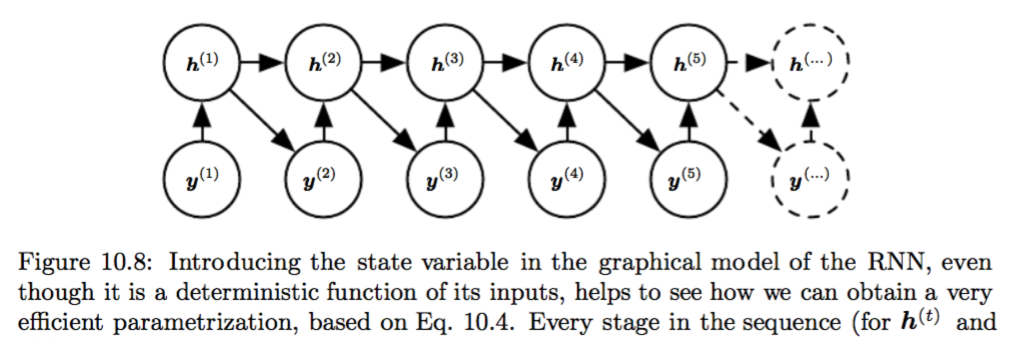

#### GRU Implementation

In [15]:
input_shape = english_padded.shape[1:]
max_words_french_data = max(fre_word_count)   # french_padded.shape[1]
english_vocab = len(unique_english_token)
french_vocab = len(unique_french_token)
learning_rate = 0.005

In [17]:
model = Sequential()
model.add(GRU(256, input_shape=input_shape, return_sequences=True))
model.add(TimeDistributed(Dense(1024, activation='relu')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(french_vocab, activation='softmax'))) 
model.summary()

# Compile model
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['accuracy'])

W0504 09:07:21.978579 139748740216640 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:72: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0504 09:07:22.026904 139748740216640 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:515: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0504 09:07:22.088088 139748740216640 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4048: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0504 09:07:23.638591 139748740216640 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_defa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 23, 256)           198144    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 23, 1024)          263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 1024)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 23, 355)           363875    
Total params: 825,187
Trainable params: 825,187
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(english_padded, french_padded, batch_size=1024, epochs=10, validation_split=0.2)

W0504 09:07:42.477420 139748740216640 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 102s 924us/step - loss: 1.8269 - acc: 0.5737 - val_loss: 1.2071 - val_acc: 0.6588
Epoch 2/10
110288/110288 [==============================] - 94s 850us/step - loss: 1.1489 - acc: 0.6691 - val_loss: 1.0031 - val_acc: 0.7015
Epoch 3/10
110288/110288 [==============================] - 116s 1ms/step - loss: 1.0054 - acc: 0.6973 - val_loss: 0.9018 - val_acc: 0.7191
Epoch 4/10
110288/110288 [==============================] - 111s 1ms/step - loss: 0.9221 - acc: 0.7116 - val_loss: 0.8321 - val_acc: 0.7277
Epoch 5/10
110288/110288 [==============================] - 120s 1ms/step - loss: 0.8655 - acc: 0.7222 - val_loss: 0.7882 - val_acc: 0.7391
Epoch 6/10
110288/110288 [==============================] - 116s 1ms/step - loss: 0.8173 - acc: 0.7347 - val_loss: 0.7213 - val_acc: 0.7584
Epoch 7/10
110288/110288 [==============================] - 118s 1ms/step - loss: 0.7767 - acc: 0.7460 - v

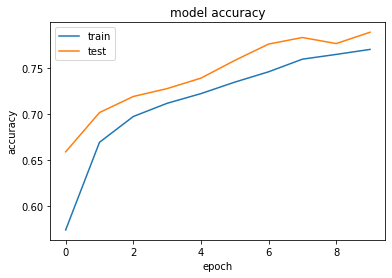

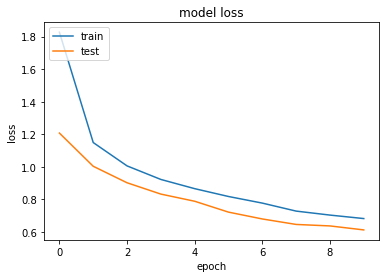

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
'''
from keras.initializers import glorot_uniform
#Reading the model from JSON file
with open('translation_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_loaded = tf.keras.models.model_from_json(json_savedModel)
model_loaded.summary()

model_loaded.load_weights('translation_model.h5')

#Compiling the model
model_loaded.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
loss,acc = model_loaded.evaluate(test_images,  test_labels, verbose=2)
''''''

In [52]:
def model_test_translation(source_padded, target_mapping, rnn_model):
    index_to_words = dict(zip(target_mapping.values(), target_mapping.keys()))
    index_to_words[0] = '<PAD>'
    
    probablities = rnn_model.predict(source_padded[:1])[0]
    prob_sentence = np.argmax(probablities,1)
    
    sent = ' '.join([index_to_words[prediction] for prediction in prob_sentence if index_to_words[prediction] not in ['<PAD>']])
    return sent, english_data['text'][0] , french_data['text'][0]
    
print(model_test_translation(english_padded, french_text_tokenizer_mapping, model))

print('===='*20)
print('Translation from google our of prediction :')
print('new jersey is sometimes hot in the month of it and it is snowy in')

('new jersey est parfois chaud en mois de il et il est neigeux en',
 'new jersey is sometimes quiet during autumn , and it is snowy in april .',
 "new jersey est parfois calme pendant l' automne , et il est neigeux en avril .")

#### LTSM Implementation

In [ ]:
learning_rate = 0.005
    
inputs = Input(input_shape)
encoder = LSTM(256)(inputs)
decoder = RepeatVector(max_words_french_data)(encoder)
decoder = LSTM(128, return_sequences=True)(decoder)
decoded = TimeDistributed(Dense(french_vocab, activation='softmax'))(decoder)

model2 = Model(inputs=inputs, outputs=decoded)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate), metrics=['accuracy'])
model2.summary()

history2 = model2.fit(english_padded, french_padded, batch_size=1024, epochs=10, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 23, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 23, 128)           197120    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 23, 355)           45795     
Total params: 507,107
Trainable params: 507,107
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 88s 798us/step - loss: 2.

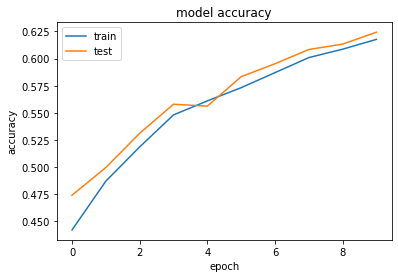

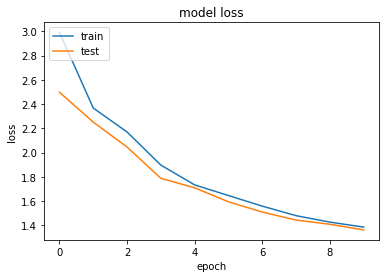

In [141]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [142]:
print(model_test_translation(english_padded, french_text_tokenizer_mapping, model2))

print('===='*20)
print('Translation from google our of prediction :')
print('new jersey is never hot in months and it is in in')

'new jersey est parfois en en mois et il est est en en'

#### Embedding Implementation
- OHE representation of word is fed into Embedding layer which is here created on the fly.
- It takes Vocab_size, max_document_length and no. of embedding vector we wish to return as an argument.
- We can think of it as a Lookup table
- Each word is represented into nD Vector representation of the words which falls closer to it and these are called Embeddings.
- Now, we will pass Embedding of each word into the neuron instead of its index.
- It's 2 layered NN which tries to capture sementic relationship among words and under the hood its just CBOW and Skip-Grams.
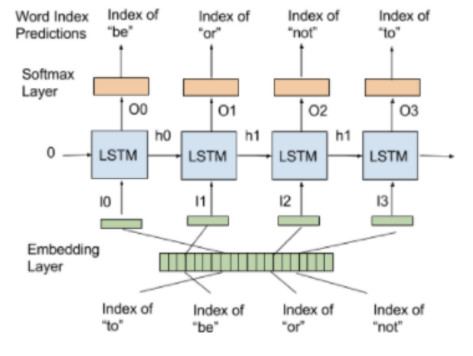

In [17]:
# To use Embeddings, we have to reshape our inputs and output 

english_padded_embedded = pad_sequences(eng_text_tokenized_vect, padding='post', maxlen = max(fre_word_count))
french_padded_embedded = french_padded

print(english_padded_embedded.shape)
print(french_padded_embedded.shape)

(137860, 23)
(137860, 23, 1)


In [22]:
#input_shape, output_sequence_length, english_vocab_size, french_vocab_size
print(english_padded_embedded.shape[1:])
print(french_padded.shape[1])
english_vocab = len(unique_english_token)
french_vocab = len(unique_french_token)
print(english_vocab)
print(french_vocab)

(23,)
23
227
355


In [46]:
embedded_model = Sequential()
embedded_model.add(Embedding(english_vocab,  # unique words in english 
                             256, 
                             input_length=english_padded_embedded.shape[1], # Max doc length
                             input_shape=english_padded_embedded.shape[1:])
                  )
embedded_model.add(GRU(256, return_sequences=True))
embedded_model.add(TimeDistributed(Dense(1024, activation='relu')))
embedded_model.add(Dropout(0.5))
embedded_model.add(TimeDistributed(Dense(french_vocab, activation='softmax'))) 
embedded_model.summary()

# Compile model
embedded_model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['accuracy'])
history3 = embedded_model.fit(english_padded_embedded, french_padded_embedded, batch_size=1024, epochs=10, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 256)           58112     
_________________________________________________________________
gru_2 (GRU)                  (None, 23, 256)           393984    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 23, 1024)          263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 1024)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 23, 355)           363875    
Total params: 1,079,139
Trainable params: 1,079,139
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 109s 990us/step - los

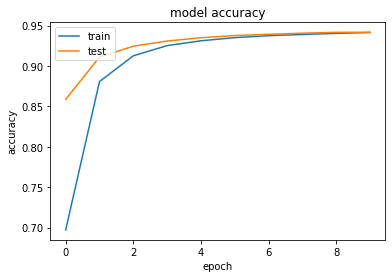

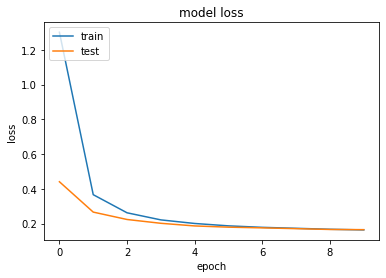

In [47]:
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
print(model_test_translation(english_padded_embedded, french_text_tokenizer_mapping, embedded_model))

print('===='*20)
print('Translation from google our of prediction :')
print('new jersey is sometimes calm in the fall and it is snowy in april')

("new jersey est parfois calme en l' automne et il est neigeux en avril", 'new jersey is sometimes quiet during autumn , and it is snowy in april .', "new jersey est parfois calme pendant l' automne , et il est neigeux en avril .")
Translation from google our of prediction :
new jersey is sometimes calm in the fall and it is snowy in april


#### B-RNN Bidirectional RNN 
- It helps to predict future word that hasn't come yet , but has dependency on some word.
- Unline RNN, It has connection in both Forward and Backword direction
- So the data flows first in Forward path and Vice-versa
- It results in 2 different outputs, which later concatened into one single output and Loss is calculated w.r.t weights of both RNN
- Audio to text is great use case , but it fails in Speech to Text conversion, where we want to convert every word uttered from mouth.
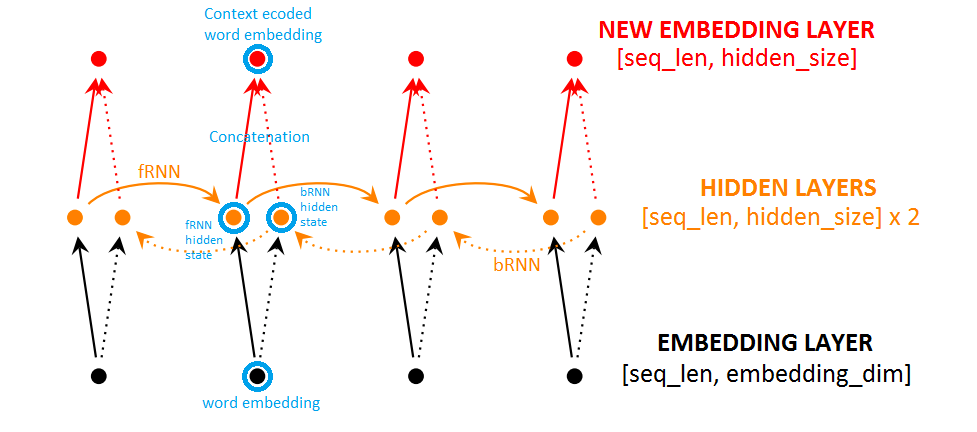

In [18]:
learning_rate = 0.005

brnn_embedded_model = Sequential()
brnn_embedded_model.add(Embedding(english_vocab,                            # unique words in english 
                             256, 
                             input_length=english_padded_embedded.shape[1], # Max doc length
                             input_shape=english_padded_embedded.shape[1:])
                  )
brnn_embedded_model.add(Bidirectional(GRU(256, return_sequences=True)))
brnn_embedded_model.add(TimeDistributed(Dense(1024, activation='relu')))
brnn_embedded_model.add(Dropout(0.5))
brnn_embedded_model.add(TimeDistributed(Dense(french_vocab, activation='softmax'))) 
brnn_embedded_model.summary()

# Compile model
brnn_embedded_model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['accuracy'])
history4 = brnn_embedded_model.fit(english_padded_embedded, french_padded_embedded, batch_size=1024, epochs=10, validation_split=0.2)

W0505 07:42:15.600356 139854936799040 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:515: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0505 07:42:15.605735 139854936799040 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4048: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0505 07:42:16.378723 139854936799040 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0505 07:42:16.389917 139854936799040 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3368: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 256)           58112     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 23, 512)           787968    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 23, 1024)          525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 1024)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 23, 355)           363875    
Total params: 1,735,267
Trainable params: 1,735,267
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 219s 2ms/step - loss:

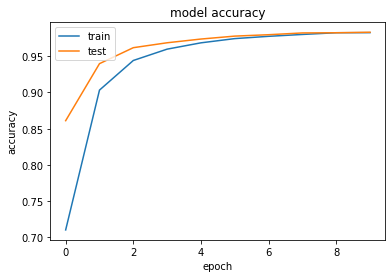

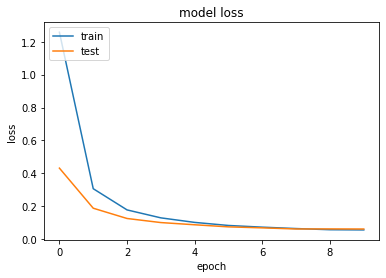

In [19]:
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
print(model_test_translation(english_padded_embedded, french_text_tokenizer_mapping, brnn_embedded_model))

print('===='*20)
print('Translation from google our of prediction :')

print('new jersey is sometimes calm during the fall and it is snowy in april')

("new jersey est parfois calme pendant l' automne et il est neigeux en avril", 'new jersey is sometimes quiet during autumn , and it is snowy in april .', "new jersey est parfois calme pendant l' automne , et il est neigeux en avril .")
Translation from google our of prediction :
new jersey is sometimes calm during the fall and it is snowy in april


In [26]:
from keras.models import model_from_json
# https://towardsdatascience.com/saving-and-loading-keras-model-42195b92f57a
# serialize model to json
json_model = brnn_embedded_model.to_json()

#save the model architecture to JSON file
with open('brnn_embedded_model.json', 'w') as json_file:
    json_file.write(json_model)
    
#saving the weights of the model
brnn_embedded_model.save_weights('brnn_embedded_model.h5')

## ENCODER - DECODER MODEL ( Sequence Modelling )
- Encoder Phase -  Words are passed into the Encoder phase and EOS is used to denote that string has reached its end.
  Output of each neuron becomes input to the next. At the end of Encoder phase, Context Vector is generated which can   be think of flattened 1D array, which becomes input of Decoder phase. It happens on different timestamp, words are   fed into different timestamps.
- Decoder Phase -  Generates output at every cell which becomes input to the next cell. It will finally output the     translation/prediction.
- Use cases : Machine Translation, Google Auto reply/suggestion, Image captioining
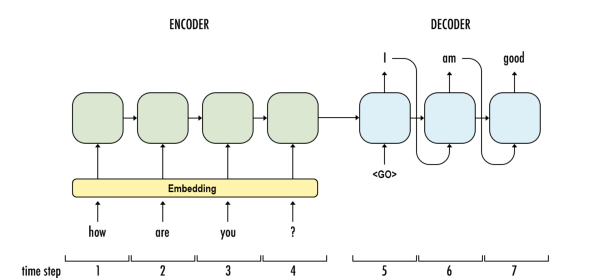

In [23]:
learning_rate = 0.005

ed_model = Sequential()
ed_model.add(Embedding(english_vocab,                                       # unique words in english 
                             256, 
                             input_length=english_padded_embedded.shape[1], # Max doc length
                             input_shape=english_padded_embedded.shape[1:])
                       )

ed_model.add(GRU(256, go_backwards=True, return_sequences=False))           # Encoder Phase
ed_model.add(RepeatVector(french_padded.shape[1]))                          # Length of output sequence
ed_model.add(GRU(256, return_sequences=True))                               # Decoder Phase
ed_model.add(TimeDistributed(Dense(1024, activation='relu')))
ed_model.add(Dropout(0.5))
ed_model.add(TimeDistributed(Dense(french_vocab, activation='softmax'))) 
ed_model.summary()

# Compile model
ed_model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['accuracy'])
history5 = ed_model.fit(english_padded_embedded, french_padded_embedded, batch_size=1024, epochs=10, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 23, 256)           58112     
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               393984    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 23, 256)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 23, 256)           393984    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 23, 1024)          263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 1024)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 23, 355)           363875    
Total para

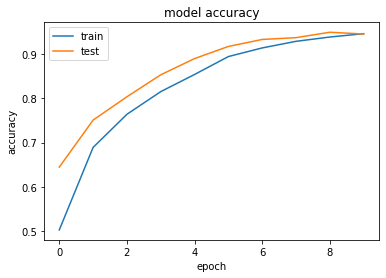

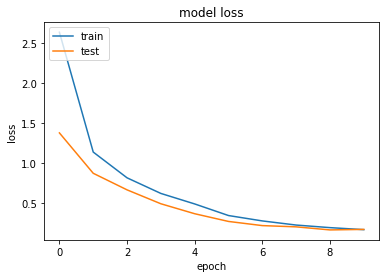

In [24]:
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
print(model_test_translation(english_padded_embedded, french_text_tokenizer_mapping, ed_model))

print('===='*20)
print('Translation from google our of prediction :')
print('new jersey is sometimes quiet in the fall and is busy in july')

("new jersey est parfois calme pendant l' automne et il est occupé en juillet", 'new jersey is sometimes quiet during autumn , and it is snowy in april .', "new jersey est parfois calme pendant l' automne , et il est neigeux en avril .")
Translation from google our of prediction :
new jersey is sometimes quiet in the fall and is busy in july
